
# **RNN: Classifying Names with a Character-Level RNN**

**Author**: `Sean Robertson <https://github.com/spro/practical-pytorch>`_

We will be building and training a basic character-level RNN to classify
words. This tutorial, along with the following two, show how to do
preprocess data for NLP modeling "from scratch", in particular not using
many of the convenience functions of `torchtext`, so you can see how
preprocessing for NLP modeling works at a low level.

A character-level RNN reads words as a series of characters -
outputting a prediction and "hidden state" at each step, feeding its
previous hidden state into each next step. We take the final prediction
to be the output, i.e. which class the word belongs to.

Specifically, we'll train on a few thousand surnames from 18 languages
of origin, and predict which language a name is from based on the
spelling:

::

    $ python predict.py Hinton
    (-0.47) Scottish
    (-1.52) English
    (-3.57) Irish

    $ python predict.py Schmidhuber
    (-0.19) German
    (-2.48) Czech
    (-2.68) Dutch




Preparing the Data
==================

.. Note::
   Download the data from
   `here <https://download.pytorch.org/tutorial/data.zip>`_
   and extract it to the current directory.

Included in the ``data/names`` directory are 18 text files named as
"[Language].txt". Each file contains a bunch of names, one name per
line, mostly romanized (but we still need to convert from Unicode to
ASCII).

We'll end up with a dictionary of lists of names per language,
``{language: [names ...]}``. The generic variables "category" and "line"
(for language and name in our case) are used for later extensibility.



In [ ]:
from __future__ import unicode_literals, print_function, division
from io import open
import glob
import os

#the glob module is used to retrieve files/pathnames matching a specified pattern.
def findFiles(path): return glob.glob(path)

print(findFiles('/content/drive/MyDrive/data/names/*.txt'))

import unicodedata
import string

all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)
print(n_letters)

# Turn a Unicode string to plain ASCII, thanks to https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s) 
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

print(unicodeToAscii('Ślusàrski'))

# Build the category_lines dictionary, a list of names per language
category_lines = {}
all_categories = []

# Read a file and split into lines
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

for filename in findFiles('/content/drive/MyDrive/data/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)
print(n_categories)

['/content/drive/MyDrive/data/names/Polish.txt', '/content/drive/MyDrive/data/names/Italian.txt', '/content/drive/MyDrive/data/names/Greek.txt', '/content/drive/MyDrive/data/names/German.txt', '/content/drive/MyDrive/data/names/Vietnamese.txt', '/content/drive/MyDrive/data/names/Arabic.txt', '/content/drive/MyDrive/data/names/Russian.txt', '/content/drive/MyDrive/data/names/Spanish.txt', '/content/drive/MyDrive/data/names/Scottish.txt', '/content/drive/MyDrive/data/names/Korean.txt', '/content/drive/MyDrive/data/names/Irish.txt', '/content/drive/MyDrive/data/names/Czech.txt', '/content/drive/MyDrive/data/names/French.txt', '/content/drive/MyDrive/data/names/Japanese.txt', '/content/drive/MyDrive/data/names/Portuguese.txt', '/content/drive/MyDrive/data/names/English.txt', '/content/drive/MyDrive/data/names/Chinese.txt', '/content/drive/MyDrive/data/names/Dutch.txt']
57
Slusarski
18


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Now we have ``category_lines``, a dictionary mapping each category
(language) to a list of lines (names). We also kept track of
``all_categories`` (just a list of languages) and ``n_categories`` for
later reference.




In [ ]:
print(category_lines['English'][:25])

['Abbas', 'Abbey', 'Abbott', 'Abdi', 'Abel', 'Abraham', 'Abrahams', 'Abrams', 'Ackary', 'Ackroyd', 'Acton', 'Adair', 'Adam', 'Adams', 'Adamson', 'Adanet', 'Addams', 'Adderley', 'Addinall', 'Addis', 'Addison', 'Addley', 'Aderson', 'Adey', 'Adkins']


**Turning Names into Tensors**
--------------------------

Now that we have all the names organized, we need to turn them into
Tensors to make any use of them.

To represent a single letter, we use a "one-hot vector" of size
``<1 x n_letters>``. A one-hot vector is filled with 0s except for a 1
at index of the current letter, e.g. ``"b" = <0 1 0 0 0 ...>``.

To make a word we join a bunch of those into a 2D matrix
``<line_length x 1 x n_letters>``.

That extra 1 dimension is because PyTorch assumes everything is in
batches - we're just using a batch size of 1 here.




In [ ]:
import torch

# Find letter index from all_letters, e.g. "a" = 0
def letterToIndex(letter):
    return all_letters.find(letter)

# Just for demonstration, turn a letter into a <1 x n_letters> Tensor
def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)] = 1
    return tensor

# Turn a line into a <line_length x 1 x n_letters>,
# or an array of one-hot letter vectors
def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

print(letterToTensor('J'))
print(lineToTensor('Jones'))
print(lineToTensor('Jones').size())

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]])
tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0.

**Creating the Network**
====================

Before autograd, creating a recurrent neural network in Torch involved
cloning the parameters of a layer over several timesteps. The layers
held hidden state and gradients which are now entirely handled by the
graph itself. This means you can implement a RNN in a very "pure" way,
as regular feed-forward layers.

This RNN module (mostly copied from `the PyTorch for Torch users
tutorial <https://pytorch.org/tutorials/beginner/former_torchies/
nn_tutorial.html#example-2-recurrent-net>`__)
is just 2 linear layers which operate on an input and hidden state, with
a LogSoftmax layer after the output.

<img src ="https://i.imgur.com/Z2xbySO.png">





In [ ]:
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size
        #nn.LSTM()   nn.GRU()
        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

n_hidden = 128
rnn = RNN(n_letters, n_hidden, n_categories)

To run a step of this network we need to pass an input (in our case, the
Tensor for the current letter) and a previous hidden state (which we
initialize as zeros at first). We'll get back the output (probability of
each language) and a next hidden state (which we keep for the next
step).




In [ ]:
input = letterToTensor('A')
hidden =torch.zeros(1, n_hidden)

output, next_hidden = rnn(input, hidden)

In [ ]:
print(output)
print(next_hidden)

tensor([[-2.9680, -2.9225, -2.9736, -2.8047, -2.9326, -2.9713, -2.9307, -2.8165,
         -2.8107, -2.9775, -2.8675, -2.9711, -2.8243, -2.8312, -2.9021, -2.7929,
         -2.8300, -2.9403]], grad_fn=<LogSoftmaxBackward>)
tensor([[ 0.0117, -0.0748, -0.0183,  0.0432, -0.0354, -0.1036,  0.0335,  0.0577,
          0.0277, -0.0314, -0.1217,  0.0205, -0.0040, -0.0654, -0.0458,  0.0663,
         -0.0262, -0.0189,  0.0321, -0.0919,  0.0280,  0.0100, -0.0984, -0.0296,
         -0.0688, -0.0557,  0.0161, -0.0910,  0.0101, -0.0254, -0.0707, -0.0145,
         -0.0223, -0.1320, -0.0667, -0.0328,  0.0256,  0.0748, -0.0014, -0.0744,
          0.0354, -0.0568,  0.0869, -0.1037,  0.1136, -0.0330, -0.0771, -0.0403,
          0.0549, -0.0408, -0.0285,  0.1119, -0.0448, -0.0206,  0.0315, -0.0155,
          0.0072, -0.0748, -0.0906, -0.0701, -0.0374, -0.0349,  0.0012, -0.0121,
          0.0392,  0.0153,  0.0077, -0.0369,  0.0411, -0.0014,  0.0888, -0.0513,
         -0.0370, -0.0860,  0.0534,  0.0869, -0.00

For the sake of efficiency we don't want to be creating a new Tensor for
every step, so we will use ``lineToTensor`` instead of
``letterToTensor`` and use slices. This could be further optimized by
pre-computing batches of Tensors.




In [ ]:
input = lineToTensor('Albert')
hidden = torch.zeros(1, n_hidden)

output, next_hidden = rnn(input[1], hidden)
print(output)

tensor([[-2.9689, -2.8547, -2.9952, -2.7793, -2.9513, -2.9815, -2.8537, -2.9310,
         -2.8001, -2.9507, -2.8787, -2.9296, -2.8803, -2.8175, -2.8644, -2.8162,
         -2.8775, -2.9325]], grad_fn=<LogSoftmaxBackward>)


As you can see the output is a ``<1 x n_categories>`` Tensor, where
every item is the likelihood of that category (higher is more likely).




**Training**
========
Preparing for Training
----------------------

Before going into training we should make a few helper functions. The
first is to interpret the output of the network, which we know to be a
likelihood of each category. We can use ``Tensor.topk`` to get the index
of the greatest value:




In [ ]:
def categoryFromOutput(output):
    top_n, top_i = output.topk(1) #Returns the k largest elements of the given input tensor along a given dimension
    category_i = top_i[0].item()
    return all_categories[category_i], category_i

print(categoryFromOutput(output))

('German', 3)


We will also want a quick way to get a training example (a name and its
language):




In [ ]:
import random

def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomTrainingExample():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor

for i in range(10):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    print('category =', category, '/ line =', line)

category = Polish / line = Sowka
category = Vietnamese / line = Huynh
category = Dutch / line = Marquering
category = Portuguese / line = Costa
category = Spanish / line = Mingo
category = Chinese / line = Cuan
category = Russian / line = Baewski
category = Greek / line = Agelakos
category = Chinese / line = Lian
category = Chinese / line = Bing


**Training the Network**
--------------------

Now all it takes to train this network is show it a bunch of examples,
have it make guesses, and tell it if it's wrong.

For the loss function ``nn.NLLLoss`` is appropriate, since the last
layer of the RNN is ``nn.LogSoftmax``.




In [ ]:
criterion = nn.NLLLoss()

Each loop of training will:

-  Create input and target tensors
-  Create a zeroed initial hidden state
-  Read each letter in and

   -  Keep hidden state for next letter

-  Compare final output to target
-  Back-propagate
-  Return the output and loss




In [ ]:
learning_rate = 0.005 # If you set this too high, it might explode. If too low, it might not learn

def train(category_tensor, line_tensor):
    hidden = rnn.initHidden()

    rnn.zero_grad()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    loss = criterion(output, category_tensor)
    loss.backward()

    # Add parameters' gradients to their values, multiplied by learning rate
    for p in rnn.parameters():
        p.data.add_(p.grad.data, alpha=-learning_rate)

    return output, loss.item()

Now we just have to run that with a bunch of examples. Since the
``train`` function returns both the output and loss we can print its
guesses and also keep track of loss for plotting. Since there are 1000s
of examples we print only every ``print_every`` examples, and take an
average of the loss.




In [ ]:
import time
import math

n_iters = 500000
print_every = 50000
plot_every = 10000



# Keep track of losses for plotting
current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss

    # Print iter number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

50000 10% (1m 4s) 1.9299 Kalb / Scottish ✗ (Arabic)
100000 20% (2m 8s) 0.7334 Duong / Vietnamese ✓
150000 30% (3m 10s) 0.0602 Neroni / Italian ✓
200000 40% (4m 12s) 0.2598 Paquet / French ✓
250000 50% (5m 14s) 0.3798 Beaulieu / French ✓
300000 60% (6m 14s) 0.3994 Giordano / Italian ✓
350000 70% (7m 14s) 3.2064 Navara / Arabic ✗ (Czech)
400000 80% (8m 14s) 0.4385 Gordon / Scottish ✓
450000 90% (9m 13s) 0.1415 Crespo / Portuguese ✓
500000 100% (10m 12s) 0.4968 Long / Chinese ✓


**Plotting the Results**
--------------------

Plotting the historical loss from ``all_losses`` shows the network
learning:




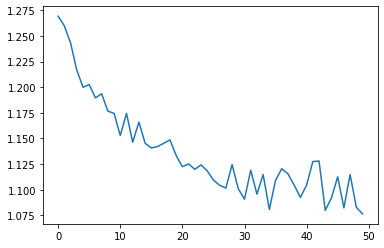

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)

In [ ]:
def evaluate(line_tensor):
    hidden = rnn.initHidden()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    return output

def predict(input_line, n_predictions=1):


    print('\n> %s' % input_line)
    with torch.no_grad():
        output = evaluate(lineToTensor(input_line))

        # Get top N categories
        topv, topi = output.topk(n_predictions, 1, True)
        predictions = []

        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print('(%.2f) %s' % (value, all_categories[category_index]))
            predictions.append([value, all_categories[category_index]])

predict('Dovesky')
predict('Jackson')
predict('Satoshi')
predict('Huzaifa')
predict('Ali')
predict("Saqib")
predict("Ruhail")


> Dovesky
(-0.44) Czech

> Jackson
(-0.63) English

> Satoshi
(-0.58) Japanese

> Huzaifa
(-0.63) Czech

> Ali
(-0.72) Italian

> Saqib
(-0.09) Arabic

> Ruhail
(-0.91) Irish
